In [2]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
import tensorflow as tf
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

/Users/carolinacraus/anaconda3/envs/cap-env/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/carolinacraus/anaconda3/envs/cap-env/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
2024-03-01 17:10:26.012833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/carolinacraus/anaconda3/envs/cap-env/lib/python3.11/site-packages/transformers/utils/generic.py

In [6]:
data = pd.read_csv("Lyrics_Clean2.csv")
data

,Unnamed: 0,Lyrics,Label,clean_lyrics,word_count_lyrics,word_count_clean_lyrics,lemmatiz,remove_stop_words,word_count_lemmatiz,word_count_stop_words,Genre
0,0,Two young people without a thing Say some vows...,0,two young people without a thing say some vows...,217,204,two young people without a thing say some vow ...,young people thing vow spread wing settle need...,215,95,Country
1,1,"Here we are, talkin' 'bout forever Both know d...",0,here we are talkin bout forever both know damn...,131,114,here we be talkin bout forever both know damn ...,talkin bout forever know damn easy ve feel lov...,119,59,Country
2,2,When I look into your soft green eyes And when...,0,when i look into your soft green eyes and when...,161,155,when I look into your soft green eye and when ...,I look soft green eye I delicate body reveal I...,158,73,Country
3,3,Way down yonder on the Chattahoochee It gets h...,0,way down yonder on the chattahoochee it gets h...,257,254,way down yonder on the chattahoochee it get ho...,way yonder chattahoochee hot hoochie coochie l...,256,125,Country
4,4,Have a little love on a little honeymoon You g...,0,have a little love on a little honeymoon you g...,267,261,have a little love on a little honeymoon you g...,little love little honeymoon little dish littl...,262,130,Country
...,...,...,...,...,...,...,...,...,...,...,...
17156,17156,Live as one will come a son Love's a thing tha...,3,live as one will come a son loves a thing that...,33,32,live as one will come a son love a thing that ...,live come son love thing love sing love tame w...,32,17,Rock
17157,17157,"Alright, my name's Gary. Let's go, it's beat t...",3,alright my names gary lets go its beat time it...,146,127,alright my name gary let go its beat time its ...,alright gary let beat time hop time monk time ...,134,75,Rock
17158,17158,"Met her on a blind date, helping out an old ma...",3,met her on a blind date helping out an old mat...,234,229,meet she on a blind date help out an old mate ...,meet blind date help old mate wait corner s dr...,232,100,Rock
17159,17159,"Got a reason to laugh, Got a reason to cry. Be...",3,got a reason to laugh got a reason to cry beli...,35,33,get a reason to laugh get a reason to cry beli...,reason laugh reason cry believe wise dumb worl...,35,14,Rock


In [7]:
df = data[['remove_stop_words', 'Label', 'Genre']].copy()
df 

,remove_stop_words,Label,Genre
0,young people thing vow spread wing settle need...,0,Country
1,talkin bout forever know damn easy ve feel lov...,0,Country
2,I look soft green eye I delicate body reveal I...,0,Country
3,way yonder chattahoochee hot hoochie coochie l...,0,Country
4,little love little honeymoon little dish littl...,0,Country
...,...,...,...
17156,live come son love thing love sing love tame w...,3,Rock
17157,alright gary let beat time hop time monk time ...,3,Rock
17158,meet blind date help old mate wait corner s dr...,3,Rock
17159,reason laugh reason cry believe wise dumb worl...,3,Rock


In [18]:
df.rename(columns={'remove_stop_words': 'Lyrics'}, inplace=True)
df

,Lyrics,Label,Genre
0,young people thing vow spread wing settle need...,0,Country
1,talkin bout forever know damn easy ve feel lov...,0,Country
2,I look soft green eye I delicate body reveal I...,0,Country
3,way yonder chattahoochee hot hoochie coochie l...,0,Country
4,little love little honeymoon little dish littl...,0,Country
...,...,...,...
17156,live come son love thing love sing love tame w...,3,Rock
17157,alright gary let beat time hop time monk time ...,3,Rock
17158,meet blind date help old mate wait corner s dr...,3,Rock
17159,reason laugh reason cry believe wise dumb worl...,3,Rock


In [20]:
class LyricsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        lyrics = str(self.data['Lyrics'].iloc[idx])
        label = int(self.data['Label'].iloc[idx])

        encoding = self.tokenizer(
            lyrics,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


### Tokenization, Train/Test Split, & Create Datasets + Dataloaders

1. Tokenization: Initializes a tokenizer from the Hugging Face transformers library. The tokenizer is based on the DistilBERT model with a cased configuration, which means it preserves the case of the text.
2. Split into training & testing sets:uses the train_test_split function from scikit-learn to split the original DataFrame (df) into training (df_train) and testing (df_test) sets. The split ratio is 80% for training and 20% for testing, and the random_state parameter is set for reproducibility.
3. Create datasets and dataloaders for training and testing: defines a maximum sequence length (MAX_LEN) for tokenization & creates instances of a custom dataset class (LyricsDataset) for both training and testing, passing the respective dataframes (df_train and df_test), the tokenizer, and the maximum sequence length.
4. Sets the batch size to 4 & creates PyTorch DataLoader objects for both training and testing datasets. The shuffle parameter is set to True for the training dataloader, which means the training data will be shuffled before each epoch.

In [21]:
# Set up tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

# Split into training and testing sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Create datasets and dataloaders for training and testing
MAX_LEN = 250
train_dataset = LyricsDataset(dataframe=df_train, tokenizer=tokenizer, max_len=MAX_LEN)
test_dataset = LyricsDataset(dataframe=df_test, tokenizer=tokenizer, max_len=MAX_LEN)

BATCH_SIZE = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [12]:
import torch
import torch.nn as nn

In [22]:
from transformers import AutoModelForSequenceClassification
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 4
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [23]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
NUM_EPOCHS = 1

In [16]:
import time 

In [28]:
#from transformers import SequenceClassifierOutput
with open('training_results3.txt', 'w') as file:

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0.0
        print("Model trained") 
        start_time = time.time() 
        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
    
            # Forward pass
            # Extract logits from SequenceClassifierOutput
            logits = outputs.logits
                
            # Calculate loss
            loss = criterion(logits, labels)
            print("Loss calculated") 
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
    
            total_loss += loss.item()
             # Print statements
            if batch_idx % 10 == 0:  # Print every 10 batches
                elapsed_time = time.time() - start_time
                file.write(f'Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Time Elapsed: {elapsed_time:.2f} seconds\n')
                print(f'Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Time Elapsed: {elapsed_time:.2f} seconds\n')
    
        average_loss = total_loss / len(train_dataloader)
        print(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Average Loss: {average_loss:.4f}')
        file.write(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Average Loss: {average_loss:.4f}\n')

        # Additional print statement after each epoch
        print(f'Epoch {epoch + 1} completed. Training loss: {average_loss:.4f}')
    
        # Print total time elapsed for the epoch
        total_epoch_time = time.time() - start_time
        file.write(f'Total Time Elapsed for Epoch {epoch + 1}: {total_epoch_time:.2f} seconds\n')
        print(f'Total Time Elapsed for Epoch {epoch + 1}: {total_epoch_time:.2f} seconds')
        
        print(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {average_loss:.4f}')
        file.write(f'Epoch {epoch + 1} completed. Training loss: {average_loss:.4f}\n')


Model trained
Loss calculated


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
import torch
import time
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader

num_classes = 4
# Define your model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define your optimizer and criterion
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()

# Assuming you have a DataLoader named train_dataloader
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0
    print(f"Training Epoch [{epoch + 1}/{NUM_EPOCHS}]")

    start_time = time.time()

    for batch_idx, batch in enumerate(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        
        # Extract logits from SequenceClassifierOutput
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print statements
        if batch_idx % 10 == 0:  # Print every 10 batches
            elapsed_time = time.time() - start_time
            print(f'Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Time Elapsed: {elapsed_time:.2f} seconds')

    average_loss = total_loss / len(train_dataloader)
    print(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}], Average Loss: {average_loss:.4f}')

    # Additional print statement after each epoch
    print(f'Epoch {epoch + 1} completed. Training loss: {average_loss:.4f}')

    # Print total time elapsed for the epoch
    total_epoch_time = time.time() - start_time
    print(f'Total Time Elapsed for Epoch {epoch + 1}: {total_epoch_time:.2f} seconds')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training Epoch [1/1]


In [12]:
torch.save(model, "DilstilBERT_Model1.pth")

In [48]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0;  nb_tr_examples=0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            targets = data['label'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = criterion(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [33]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [50]:
# Function to calcuate the accuracy of the model

def calculate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct
# Evaluation loop
model.eval()  # Set the model to evaluation mode
total_loss, total_accuracy = 0, 0

with torch.no_grad():  # Disable gradient calculation during evaluation
    for batch_idx, batch in enumerate(test_dataloader):
        ids, mask, targets = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['label'].to(device)

        # Forward pass
        outputs = model(ids, attention_mask=mask)
        targets = targets.to(torch.long)  # Convert targets to float
        loss = criterion(outputs, targets)

        total_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        total_accuracy += calculate_accu(big_idx, targets.to(torch.long))  # Convert targets back to long

        if batch_idx % 10 == 0:
            print(f'Test Batch {batch_idx}/{len(test_dataloader)}, Loss: {loss.item()}')

# Print test loss and accuracy
avg_loss = total_loss / len(test_dataloader)
avg_accuracy = total_accuracy / len(test_dataset)

print(f'Test Loss: {avg_loss}, Test Accuracy: {avg_accuracy}')

Test Batch 0/687, Loss: 0.17997294664382935



KeyboardInterrupt



In [51]:
acc = valid(model, test_dataloader)
print("Accuracy on test data = %0.2f%%" % acc)

Validation Loss per 100 steps: 0.17997294664382935
Validation Accuracy per 100 steps: 100.0
Validation Loss Epoch: 0.8082615259975151
Validation Accuracy Epoch: 62.418062636562276
Accuracy on test data = 62.42%


In [55]:
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

all_predictions, all_targets = [], []

def valid(model, testing_loader):
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            targets = data['label'].to(device, dtype=torch.long)
            outputs = model(ids, mask).squeeze()
            loss = criterion(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calculate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)
            # Collect predictions and actual targets
            all_predictions.extend(big_idx.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            if nb_tr_steps % 1000 == 0:
            train_losses.append(tr_loss / nb_tr_steps)
            train_accuracies.append((n_correct * 100) / nb_tr_examples)
            print(f"Epoch [{epoch + 1}/{num_epochs}], "
                    f"Training Loss per 1000 steps: {train_losses[-1]:.4f}, "
                    f"Training Accuracy per 1000 steps: {train_accuracies[-1]:.2f}")

                
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

acc = valid(model, test_dataloader)
print("Accuracy on test data = %0.2f%%" % acc)


Validation Loss per 1000 steps: 0.17997294664382935
Validation Accuracy per 1000 steps: 100.0
Validation Loss Epoch: 0.8082615259975151
Validation Accuracy Epoch: 62.418062636562276
Accuracy on test data = 62.42%


In [63]:
model_outputs = model(ids, mask).squeeze()

# Apply softmax to get predicted probabilities
predicted_probabilities = F.softmax(model_outputs, dim=1)[:, 1].cpu().detach().numpy()


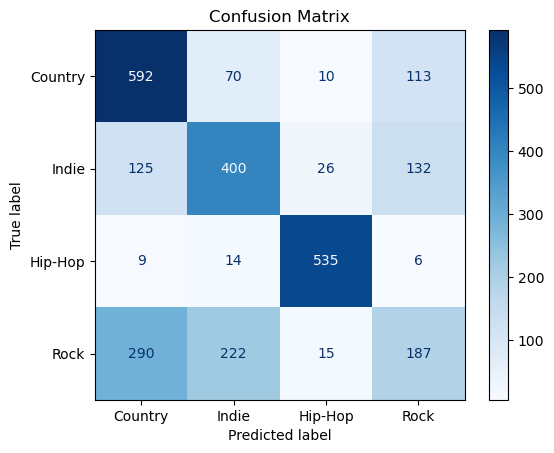

In [61]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

class_names = class_names = ["Country", "Indie", "Hip-Hop", "Rock"]

# Create a confusion matrix
conf_matrix = metrics.confusion_matrix(all_targets, all_predictions)

# Create ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)

# Plot the confusion matrix
cm_display.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()